In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 8]

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import minerl
from tqdm import tqdm

from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utilities import flatten, unflatten, to_batch_shape, to_torch_channels
from collections import defaultdict
import coordconv

from networks import ConvNeXtBlock, SimpleLayerNorm
from spectralpool import SpectralPool2d
import collections
from autoencoder import VAELatent

import shapes_dataset
from dataset_preprocessing import MineRlSequenceDataset, MineRlImageDataset
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import AdvancedAutoencoder
import autoencoder
from ZerO import init_ZerO
from networks import SkippableLayerNorm
from lion_pytorch import Lion

/home/marthinwurer/.pyenv/versions/3.9.6/envs/minerl/lib/python3.9/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [5]:
import gym
import crafter

In [7]:
env = gym.make('CrafterReward-v1')  # Or CrafterNoReward-v1
env = crafter.Recorder(
  env, './logs/',
  save_stats=True,
  save_video=False,
  save_episode=False,
)

In [20]:
steps = 0
obs = env.reset()
done = False
while not done:
    steps += 1
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

In [21]:
steps

237

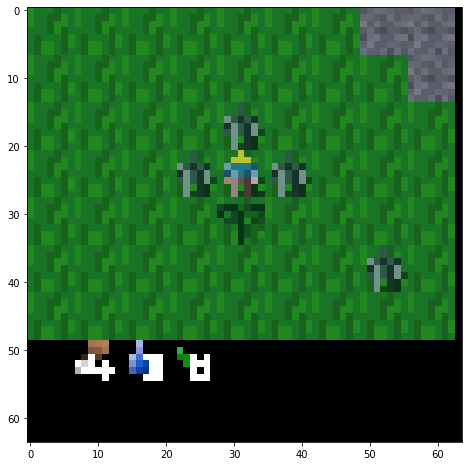

In [10]:
plt.imshow(obs)

In [11]:
# Next steps: implement the random sampling from the world models paper. 
# store the data in a buffer to save for later to train on.

In [17]:
info['semantic']

array([[1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 6, 6, 2],
       ...,
       [5, 2, 6, ..., 3, 2, 2],
       [2, 2, 2, ..., 3, 3, 3],
       [2, 2, 2, ..., 8, 3, 3]], dtype=uint8)

In [14]:
obs.shape

(64, 64, 3)

In [22]:
action

9

In [26]:
import os

In [36]:
class CrafterReplayBuffer:
    def __init__(self, output_dir, size):
        
        os.makedirs(output_dir)  # make sure this errors if it exists so we don't overwrite any data
        
        self.size = size
        self.pov = np.memmap(output_dir + '/pov.npy', dtype='uint8', mode='w+', shape=(size, 64, 64, 3))
        self.povn = np.memmap(output_dir + '/pov_next.npy', dtype='uint8', mode='w+', shape=(size, 64, 64, 3))
        self.action = np.memmap(output_dir + '/action.npy', dtype='uint8', mode='w+', shape=(size))
        self.reward = np.memmap(output_dir + '/reward.npy', dtype='f', mode='w+', shape=(size))
        self.done = np.memmap(output_dir + '/done.npy', dtype='?', mode='w+', shape=(size))
        self.written = 0
    
    def append(self, s, a, r, s_n, d):
        self.pov[self.written] = s
        self.povn[self.written] = s_n
        self.action[self.written] = a
        self.reward[self.written] = r
        self.done[self.written] = d
        self.written += 1

In [49]:
# build the crafter dataset world models style

In [50]:
rb = CrafterReplayBuffer("./data/crafter", 1000000)

In [51]:
for i in tqdm(range(10000)):
    steps = 0
    obs = env.reset()
    done = False
    while not done:
        prev = obs
        steps += 1
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        rb.append(prev, action, reward, obs, done)

 59%|███████████████████████████████████▌                        | 5933/10000 [50:35<34:40,  1.95it/s]


IndexError: index 1000000 is out of bounds for axis 0 with size 1000000

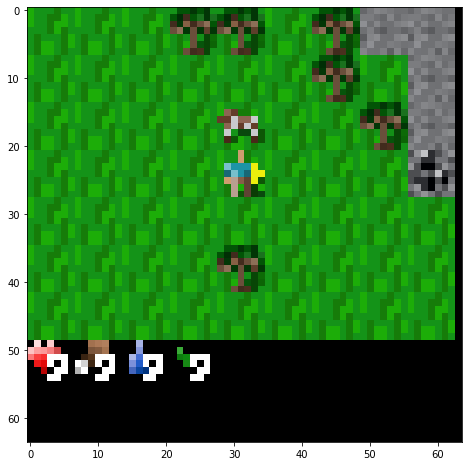

In [52]:
plt.imshow(rb.pov[-1])

In [56]:
np.unique(rb.done, return_counts=True)

(array([False,  True]), array([994067,   5933]))

In [57]:
class CrafterImageDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        initial_size = 1000000
        self.transform = transform
        self.pov = np.memmap(base_dir + '/pov.npy', dtype='uint8', mode='r', shape=(initial_size, 64, 64, 3))

    def __len__(self):
        return self.pov.shape[0]

    def __getitem__(self, idx):
        image = self.pov[idx]
        if self.transform:
            image = self.transform(image)
        return image

In [58]:
cid = CrafterImageDataset("./data/crafter")

In [59]:
train_dataloader = DataLoader(cid, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

In [66]:
data = next(iter(train_dataloader))
image = data[0]

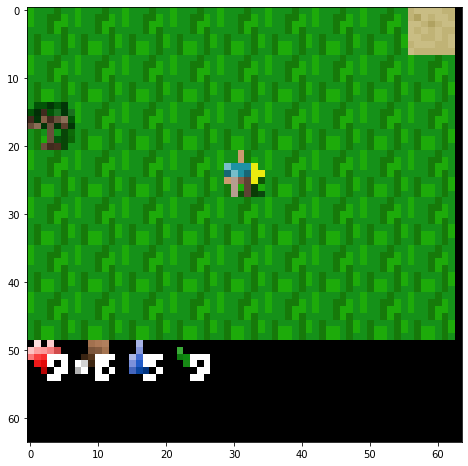

In [67]:
plt.imshow(image.numpy())